<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Sentiment_Analysis_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import gensim
import nltk
from gensim.models.word2vec import Word2Vec
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving Demo1 clean.csv to Demo1 clean.csv


In [103]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['Demo1 clean.csv']))

In [104]:
data.head()

,Unnamed: 0,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment
0,0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,experience rancho valencia absolutely perfect ...,5,"['experience', 'rancho', 'valencia', 'absolute...",Positive
1,1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,amazing place everyone extremely warm welcomin...,5,"['amazing', 'place', 'everyone', 'extremely', ...",Positive
2,2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,booked 3 night stay rancho valencia play tenni...,5,"['booked', '3', 'night', 'stay', 'rancho', 'va...",Positive
3,3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,currently bed writing past hr 12 dogs barking ...,2,"['currently', 'bed', 'writing', 'past', 'hr', ...",Negative
4,4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,live md aloft home away homewe stayed 1 night ...,5,"['live', 'md', 'aloft', 'home', 'away', 'homew...",Positive


In [105]:
# Print Multiple statements in same line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [106]:
# Explore data
data.shape
type(data)
data.size
data.tail()

(9999, 10)

pandas.core.frame.DataFrame

99990

,Unnamed: 0,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment
9994,9994,AVwd4TMv_7pvs4fz-Ers,Silver Sands Oceanfront Motel,Gorgeous outlook on to beach/water/sun,runninghappy,Small town on the state route - unexpected del...,small town state route unexpected delight hote...,5,"['small', 'town', 'state', 'route', 'unexpecte...",Positive
9995,9995,AVwd4TMv_7pvs4fz-Ers,Silver Sands Oceanfront Motel,Picture Window Ocean View!,LASH0211,It is hard for me to review an oceanfront hote...,hard review oceanfront hotel go ocean necessar...,3,"['hard', 'review', 'oceanfront', 'hotel', 'go'...",Negative
9996,9996,AVwdRp4DIN2L1WUfuGZZ,Sandy Neck Motel,"Clean, comfortable and quiet",Gennaker,"I live close by, and needed to stay somewhere ...",live close needed stay somewhere night due ren...,4,"['live', 'close', 'needed', 'stay', 'somewhere...",Positive
9997,9997,AVwd1TbkByjofQCxs6FH,Shilo Inn Suites - Coeur d'Alene,Passing through,Amber406,Rolled in 11:30 laid out heads down woke up to...,rolled 1130 laid heads woke continental breakf...,4,"['rolled', '1130', 'laid', 'heads', 'woke', 'c...",Positive
9998,9998,AVwdHbizIN2L1WUfsXto,Scottish Inn,Terrible,donWoodbury,Absolutely terrible..I was told I was being gi...,absolutely terriblei told given non smoking ro...,1,"['absolutely', 'terriblei', 'told', 'given', '...",Negative


In [107]:
# Check for missing values
pd.isnull(data).any()
pd.isnull(data).sum()

Unnamed: 0    False
Hotel_id      False
Hotel         False
Title          True
Users         False
Reviews        True
Text_Clean     True
Rating        False
tokens        False
Sentiment     False
dtype: bool

Unnamed: 0    0
Hotel_id      0
Hotel         0
Title         1
Users         0
Reviews       1
Text_Clean    3
Rating        0
tokens        0
Sentiment     0
dtype: int64

In [108]:
#Find out types of each Variables. Object means string or categorical in the below output
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9999 non-null   int64 
 1   Hotel_id    9999 non-null   object
 2   Hotel       9999 non-null   object
 3   Title       9998 non-null   object
 4   Users       9999 non-null   object
 5   Reviews     9998 non-null   object
 6   Text_Clean  9996 non-null   object
 7   Rating      9999 non-null   int64 
 8   tokens      9999 non-null   object
 9   Sentiment   9999 non-null   object
dtypes: int64(2), object(8)
memory usage: 781.3+ KB


In [109]:
data.describe()


,Unnamed: 0,Rating
count,9999.000000,9999.000000
mean,4999.000000,3.982698
std,2886.607005,1.175107
min,0.000000,1.000000
25%,2499.500000,3.000000
50%,4999.000000,4.000000
75%,7498.500000,5.000000
max,9998.000000,5.000000


In [110]:
#Filing the missing Review with 'na'
data['Reviews'] = data['Reviews'].fillna('').apply(str)
data['Text_Clean'] = data['Text_Clean'].fillna('').apply(str)
data['Title'] = data['Title'].fillna('').apply(str)



In [111]:
#Drop the rows where at least one element is missing
data.dropna(inplace=True)


In [112]:
# The sentiment should be binary encoded with 1 for "Positive" and 0 for "Negative" sentiment using list comprehension
data['Sentiment'] = [1 if x > 3 else 0 for x in data.Rating]


In [113]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [114]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [115]:
X = []
sentences = list(data['Reviews'])
for sen in sentences:
    X.append(preprocess_text(sen))

**Data Preprocessing**

In [116]:
# RNN input requires array data type, therefore, we convert the “Reviews” into the X array and “Sentiment” into the y array accordingly.
X, y = (data['Reviews'].values, data['Sentiment'].values)


In [117]:
# Text data has to be integer encoded before feeding it into the RNN model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tk = Tokenizer(lower = True)
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')

In [118]:
print(tk.word_index)

{'the': 1, 'and': 2, 'was': 3, 'to': 4, 'a': 5, 'i': 6, 'in': 7, 'we': 8, 'for': 9, 'of': 10, 'is': 11, 'hotel': 12, 'room': 13, 'very': 14, 'it': 15, 'this': 16, 'were': 17, 'at': 18, 'with': 19, 'you': 20, 'staff': 21, 'on': 22, 'but': 23, 'stay': 24, 'that': 25, 'not': 26, 'our': 27, 'had': 28, 'more': 29, 'great': 30, 'good': 31, 'clean': 32, 'my': 33, 'have': 34, 'are': 35, 'breakfast': 36, 'nice': 37, 'there': 38, 'they': 39, 'as': 40, 'from': 41, 'rooms': 42, 'so': 43, 'be': 44, 'friendly': 45, 'all': 46, 'location': 47, 'would': 48, 'stayed': 49, 'comfortable': 50, 'us': 51, 'your': 52, 'out': 53, 'here': 54, 'no': 55, 'one': 56, 'when': 57, 'time': 58, 'night': 59, 'place': 60, 'area': 61, 'an': 62, 'service': 63, 'again': 64, 'helpful': 65, 'only': 66, 'well': 67, 'if': 68, 'will': 69, 'desk': 70, 'bad': 71, 'bed': 72, 'front': 73, 'just': 74, 'pool': 75, 'get': 76, 'up': 77, 'or': 78, 'like': 79, 'which': 80, 'me': 81, 'back': 82, 'check': 83, 'about': 84, 'by': 85, 'did': 8

In [119]:
X_pad

array([[  27,  119,   18, ...,    0,    0,    0],
       [ 191,   60,  371, ...,    0,    0,    0],
       [   8,  179,    5, ...,    0,    0,    0],
       ...,
       [   6,  868,   91, ...,    0,    0,    0],
       [3230,    7,  800, ...,    0,    0,    0],
       [ 521,  661,    6, ...,    0,    0,    0]], dtype=int32)

In [120]:
# Train-Test split and keeping 25% of original data as a hold out set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.2, random_state = 1)

In [121]:
# The training set can be split into training and validation set
batch_size = 32
X_train1 = X_train[batch_size:]
y_train1 = y_train[batch_size:]
X_valid = X_train[:batch_size]
y_valid = y_train[:batch_size]

In [122]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [123]:
vocabulary_size = len(tk.word_counts.keys())+1
max_words = 100

In [124]:
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(200))
model.add(Dense(1, activation='sigmoid'))

In [125]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [126]:
history = model.fit(X_train1,y_train1,validation_data=(X_valid,y_valid),batch_size=batch_size,epochs=5)

Epoch 1/5
249/249 [==============================] - 51s 207ms/step - loss: 0.5787 - accuracy: 0.7334 - val_loss: 0.7027 - val_accuracy: 0.6562
Epoch 2/5
249/249 [==============================] - 52s 207ms/step - loss: 0.5706 - accuracy: 0.7431 - val_loss: 0.7085 - val_accuracy: 0.6250
Epoch 3/5
249/249 [==============================] - 52s 208ms/step - loss: 0.5546 - accuracy: 0.7542 - val_loss: 0.7060 - val_accuracy: 0.6250
Epoch 4/5
249/249 [==============================] - 53s 213ms/step - loss: 0.5430 - accuracy: 0.7606 - val_loss: 0.6086 - val_accuracy: 0.6562
Epoch 5/5
249/249 [==============================] - 52s 210ms/step - loss: 0.5691 - accuracy: 0.7448 - val_loss: 0.7289 - val_accuracy: 0.5625


In [133]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:" ,scores[1])

Test Accuracy: 0.7179999947547913


Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

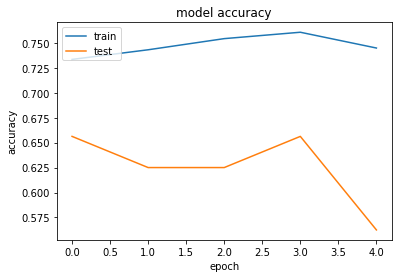

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

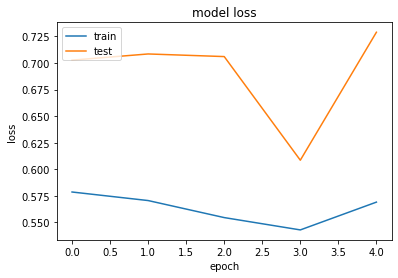

In [134]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [130]:
# Prepare reviews for check
Check_set = data.Reviews.values
Check_seq = tk.texts_to_sequences(Check_set)
Check_pad = pad_sequences(Check_seq, maxlen = 100, padding = 'post')

In [131]:
# Predict sentiment
check_predict = model.predict_classes(Check_pad, verbose = 0)

In [132]:
# Prepare data frame
check_df = pd.DataFrame(list(zip(data.Reviews.values, data.Rating.values, check_predict)), columns = ['Reviews','Rating','Sentiment'])
check_df.Sentiment = ['Pos' if x == [1] else 'Neg' for x in check_df.Sentiment]
check_df

,Reviews,Rating,Sentiment
0,Our experience at Rancho Valencia was absolute...,5,Pos
1,Amazing place. Everyone was extremely warm and...,5,Pos
2,We booked a 3 night stay at Rancho Valencia to...,5,Pos
3,Currently in bed writing this for the past hr ...,2,Pos
4,I live in Md and the Aloft is my Home away fro...,5,Pos
...,...,...,...
9994,Small town on the state route - unexpected del...,5,Pos
9995,It is hard for me to review an oceanfront hote...,3,Pos
9996,"I live close by, and needed to stay somewhere ...",4,Pos
9997,Rolled in 11:30 laid out heads down woke up to...,4,Pos
